# Retrieval-Augmented Generation(RAG) from Scratch with FTS, Vector Search and Hybrid Search

In this notebook, we will build a Retrieval-Augmented Generation(RAG) pipeline from scratch without using any popular libraries such as Langchain or Llamaindex.

RAG is a technique that retrieves related documents to the user's question, combines them with LLM-base prompt, and sends them to LLMs like GPT to produce more factually accurate generation.

Lets Split RAG Pipeline into 5 parts:

1. Data loading
2. Chunking and Embedding
3. Ingest data in Vector Store
4. FTS, Vector Search and Hybrid search Retrieval & Prompt preparation
5. Answer Generation using results of FTS, Vector Search and Hybrid search all of them

Here is an image illustrating the RAG process

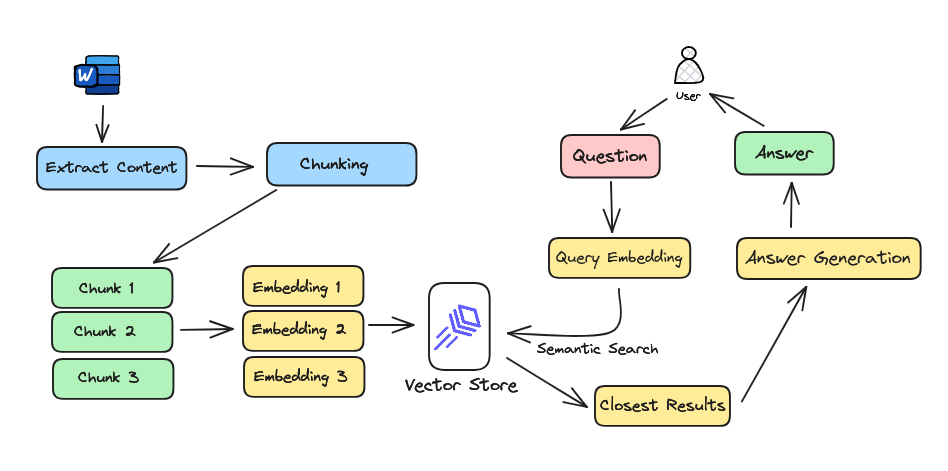

## Install Dependencies

In [1]:
# Install
!pip install transformers scikit-learn docx2txt datasets nltk lancedb openai==0.28 tantivy pylance -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.6/229.6 kB 14.0 MB/s eta 0:00:00


### Set OPENAI API KEY as env variable

In [47]:
# Set OPENAI_API_KEY

import os
from dotenv import load_dotenv
import openai
from google.colab import files

# This will prompt you to upload .env which contains api keys
uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]

load_dotenv(file_name)

api_key = os.getenv("OPENAI_API_KEY_20B")
open_router_key = os.getenv("OPENROUTER_API_KEY")

openai.api_key = api_key

#from google.colab import userdata
#gpt_key= userdata.get('gpt')
print(f"{open_router_key[:5]}")


Saving .env to .env (1)
sk-or


## Data Loading

In [3]:
print(f"{api_key[:5]}")
# Load text
!wget https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/tutorials/RAG-from-Scratch/lease.txt

# !wget link
with open("lease.txt", "r") as file:
    text_data = file.read()

sk-or-
--2025-09-11 03:07:23--  https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/tutorials/RAG-from-Scratch/lease.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5248 (5.1K) [text/plain]
Saving to: ‘lease.txt’

lease.txt           100%[===================>]   5.12K  --.-KB/s    in 0s      

2025-09-11 03:07:23 (48.8 MB/s) - ‘lease.txt’ saved [5248/5248]



## Data Chunking and Embedding

In [4]:
# Recursive Text Splitter

import nltk

nltk.download("punkt")
from nltk.tokenize import sent_tokenize
import re


def recursive_text_splitter(text, max_chunk_length=1000, overlap=100):
    """
    Helper function for chunking text recursively
    """
    # Initialize result
    result = []

    current_chunk_count = 0
    separator = ["\n", " "]
    _splits = re.split(f"({separator})", text)
    splits = [_splits[i] + _splits[i + 1] for i in range(1, len(_splits), 2)]

    for i in range(len(splits)):
        if current_chunk_count != 0:
            chunk = "".join(
                splits[
                    current_chunk_count
                    - overlap : current_chunk_count
                    + max_chunk_length
                ]
            )
        else:
            chunk = "".join(splits[0:max_chunk_length])

        if len(chunk) > 0:
            result.append("".join(chunk))
        current_chunk_count += max_chunk_length

    return result

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
chunks = recursive_text_splitter(text_data, max_chunk_length=100, overlap=10)
print("Number of Chunks: ", len(chunks))

Number of Chunks:  11


## Vector Store

In [6]:
# Insert text chunks with their embeddings

import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector


embeddings = (
    get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5")
)


class Documents(LanceModel):
    vector: Vector(embeddings.ndims()) = embeddings.VectorField()
    text: str = embeddings.SourceField()


def prepare_data(chunks, embeddings):
    """
    Helper function to prepare data to insert in LanceDB
    """
    data = []
    for chunk, embed in zip(chunks, embeddings):
        temp = {}
        temp["text"] = chunk
        temp["vector"] = embed
        data.append(temp)
    return data


def lanceDBConnection(chunks):
    """
    LanceDB insertion
    """

    db = lancedb.connect("/tmp/lancedb")
    # data = prepare_data(chunks, embeddings)
    table = db.create_table("documents", schema=Documents, mode="overwrite")

    data = [{"text": s} for s in chunks]
    # ingest data in table
    table.add(data)
    return table


# create and add table in table
table = lanceDBConnection(chunks)

# Create a fts index before the hybrid search
table.create_fts_index("text", replace=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Retriever & Prompt preparation

## Query Type: FTS

In [7]:
# Retriever
question = "What is issue date of lease?"

# FTS Search
fts_result = table.search(question, query_type="fts").limit(5).to_list()

# Hybrid Search
# import numpy as np

# query = np.random.random(384)

# text_query = question
# (
#     table.search(query_type="hybrid")
#     .vector(query)
#     .text(question)
#     .limit(5)
#     .to_list()
# )

In [8]:
fts_context = [r["text"] for r in fts_result]
fts_context

[' as defined in Section 2 of this Article II, and shall terminate on May 31, 2020 ("the Termination Date"); provided, however, that at the option of Tenant, Tenant may renew this Lease for five additional successive one- year terms at a Monthly Rent of $100,000 per month, provided that notice of such renewal is given in writing no less than 120 days prior to the Termination Date or the expiration of any one-year renewal term. Tenant may at any time cancel this Lease and terminate all of its obligations hereunder by the payment of $300,000, plus all other amounts then due',
 ' of $300,000, plus all other amounts then due under this Lease.\n\n\n\nSection 2.  Commencement Date. The "Commencement Date" shall mean  December 1, 2013.\n\n\n\nARTICLE III - EXTENSIONS\n\n\n\nThe parties hereto may elect to extend this Agreement upon such terms and conditions as may be agreed upon in writing and signed by the parties at the time of any such extension.\n\n\n\nARTICLE IV - DETERMINATION OF RENT\n

## Query Type: Vector Search

In [9]:
# Retriever
question = "What is issue date of lease?"

# Vector Search
vs_result = table.search(question, query_type="vector").limit(10).to_list()

In [10]:
vs_context = [r["text"] for r in vs_result]
vs_context

[' as defined in Section 2 of this Article II, and shall terminate on May 31, 2020 ("the Termination Date"); provided, however, that at the option of Tenant, Tenant may renew this Lease for five additional successive one- year terms at a Monthly Rent of $100,000 per month, provided that notice of such renewal is given in writing no less than 120 days prior to the Termination Date or the expiration of any one-year renewal term. Tenant may at any time cancel this Lease and terminate all of its obligations hereunder by the payment of $300,000, plus all other amounts then due',
 ' of $300,000, plus all other amounts then due under this Lease.\n\n\n\nSection 2.  Commencement Date. The "Commencement Date" shall mean  December 1, 2013.\n\n\n\nARTICLE III - EXTENSIONS\n\n\n\nThe parties hereto may elect to extend this Agreement upon such terms and conditions as may be agreed upon in writing and signed by the parties at the time of any such extension.\n\n\n\nARTICLE IV - DETERMINATION OF RENT\n

## Perform inbuilt Hybrid Search
They have some off the shelf functionalities and a way to implement the custom Re-Ranking and Filtering Function here [Implement Custom Rerankers](https://lancedb.github.io/lancedb/hybrid_search/#building-custom-rerankers)

In [11]:
from lancedb.rerankers import LinearCombinationReranker

reranker = LinearCombinationReranker(
    weight=0.7
)  # Weight = 0 Means pure Text Search (BM-25) and 1 means pure Sementic (Vector) Search

hs_result = (
    table.search(
        question,
        query_type="hybrid",
    )
    .rerank(reranker=reranker)
    .limit(5)
    .to_list()
)

hs_context = [r["text"] for r in hs_result]
hs_context

[' released from all liability for the return of such security to the Tenant.\n\n\n\nARTICLE VI - TAXES\n\n\n\nSection l.  Personal Property Taxes.  The Tenant shall be liable for all taxes levied against any leasehold interest of the Tenant or personal property and trade fixtures owned or placed by the Tenant in the Leased Premises.\n\n\n\nSection 2.  Real Estate Taxes.  During the continuance of this lease Landlord shall deliver to Tenant a copy of any real estate taxes and assessments against the Leased Property. From and after the Commencement Date, the Tenant shall pay to Landlord not',
 " Commencement Date, the Tenant shall pay to Landlord not later than twenty-one (21) days after the day on which the same may become initially due, all real estate taxes and assessments applicable to the Leased Premises, together with any interest and penalties lawfully imposed thereon as a result of Tenant's late payment thereof, which shall be levied upon the Leased Premises during the term of t

In [12]:
# Context Prompt

base_prompt = """You are an AI assistant. Your task is to understand the user question, and provide an answer using the provided contexts. Every answer you generate should have citations in this pattern  "Answer [position].", for example: "Earth is round [1][2].," if it's relevant.

Your answers are correct, high-quality, and written by an domain expert. If the provided context does not contain the answer, simply state, "The provided context does not have the answer."

User question: {}

Contexts:
{}
"""

## Answer Generation

### Using FTS result

In [13]:
import openai

# Your prompt
prompt = f"{base_prompt.format(question, fts_context)}"

openai.api_base = "https://openrouter.ai/api/v1"

response = openai.ChatCompletion.create(
    model="openai/gpt-oss-20b", # Use the appropriate model name for OpenRouter
    temperature=0,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ],
)

print(response.choices[0].message["content"])

The provided context does not have the answer.


### Using Vector Search result

In [14]:
# Your prompt
import openai

# Your prompt
prompt = f"{base_prompt.format(question, vs_context)}"

openai.api_base = "https://openrouter.ai/api/v1"

response = openai.ChatCompletion.create(
    model="openai/gpt-oss-20b", # Use the appropriate model name for OpenRouter
    temperature=0,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ],
)

print(response.choices[0].message["content"])

The lease was issued on **December 1, 2013**【6】.


### Using Hybrid Search result

In [15]:
# Your prompt
prompt = f"{base_prompt.format(question, hs_context)}"


openai.api_base = "https://openrouter.ai/api/v1"

response = openai.ChatCompletion.create(
    model="openai/gpt-oss-20b", # Use the appropriate model name for OpenRouter
    temperature=0,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ],
)

print(response.choices[0].message["content"])

The provided context does not have the answer.


### Exercises

Here are some exercises to further explore and enhance the RAG pipeline:

1.  **Experiment with different chunking strategies:**
    *   Modify the `recursive_text_splitter` function to use different separators or chunk sizes.
    *   Compare the retrieval results of FTS, Vector Search, and Hybrid Search with different chunking strategies.
2.  **Implement a different embedding model:**
    *   Explore other embedding models available .
    *   Replace the current embedding model with a different one and evaluate its impact on retrieval performance.
3.  **Add more documents:**
    *   Download or use your own documents (e.g., PDF, DOCX) to expand the knowledge base.
    *   Modify the data loading and processing steps to handle multiple document types.
4.  **Evaluate retrieval performance:**
    *   Define a set of test questions and manually evaluate the relevance of the retrieved chunks for each search type (FTS, Vector Search, Hybrid).
    *   Consider using metrics if you have a labeled dataset.
6.  **Explore different LLMs from OpenRouter:**
    *   If you have access to other LLMs, experiment with using them for answer generation and compare the quality of the responses.

# Step 1: Install required libraries

In [50]:
!pip install PyPDF2 python-docx langchain sentence-transformers transformers faiss-cpu openai==1.46.0 numpy

# Step 2: All necesseary imports.

In [37]:
import os
import re
from PyPDF2 import PdfReader
from docx import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
import openai

# Step 3: Upload your pdf/docx files (you can upload multiple files)

In [38]:
uploaded = files.upload()
file_names = list(uploaded.keys())

Saving Nutrition_Guide.pdf to Nutrition_Guide (3).pdf


# Step 4: Extraxt text from All uploaded files.

In [39]:
all_texts = []

for file_name in file_names:
    if file_name.lower().endswith('.pdf'):
        reader = PdfReader(file_name)
        text = ""
        for page in reader.pages:
            try:
                text += page.extract_text() + "\n"
            except Exception as e:
                print(f"Error reading Page from {file_name}: {e}")
                continue
        all_texts.append(text)
    elif file_name.lower().endswith('.docx'):
        doc = Document(file_name)
        text = "\n".join([para.text for para in doc.paragraphs])
        all_texts.append(text)
    else:
        print(f"Skipping unsupported format: {file_name}")

# Combine all texts into one string
pdf_text = "\n\n".join(all_texts)
print(f"Successfully processed {len(all_texts)} documents")


Error reading Nutrition_Guide (3).pdf: Invalid Elementary Object starting with b'\xc0' @8509515: b'0`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c'
Error reading Nutrition_Guide (3).pdf: Invalid Elementary Object starting with b'\xc0' @8626397: b'0`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c'
Error reading Nutrition_Guide (3).pdf: cannot access local variable 'cm' where it is not associated with a value
Error reading Nutrition_Guide (3).pdf: Invalid Elementary Object starting with b'\x1c' @8866924: b'\xf8\x9c\xd7S_\x1c .\x18`\x80x\x01}~\x9f .8\x06\x1c\x9

Error reading Nutrition_Guide (3).pdf: Invalid Elementary Object starting with b'\xd5' @12323028: b',P\xd9\\}&\xe0g\x01/\xa9\x1a\n\xbb1\x0c\xca5\xdc\r\xd5\x93\xb8K*\x1f7\xd7\xe7\xe3\xee\xb4\xc7\xdd\xe9\xc6\xdc\x9d\xcc&I0\x9a]\xce\xce\x93`D\x1a=\x8d\xbb\xdd>\xf9b\xf0N\x85\xb9\xf4\x98&\x82wv=\xcf\xf5\x17\xfa\x10wY\x93\x9fK\xe7y'
Error reading Nutrition_Guide (3).pdf: Invalid Elementary Object starting with b'\xc0' @12406117: b'0`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c\x180`\xc0\x80\x01\x03\x06\x0c'
Error reading Nutrition_Guide (3).pdf: Invalid Elementary Object starting with b'S' @13133560: b'\xc6#\xa6\xce\x80\xf2\x07\x14\x99c\xc5\xd4BL\xb4)\x0b\xfc\xd5\x18Sb\x03\x9f\x12K\xaad>\x12\x00\xd6`\x14\xe2\xb9\xac\x9a%\x89G\xfb\xa1\xbcR\x15\x94/\xfd;f|\x96\xa9\x15\xa6>jj\x9e\xa9\xe5\xe6\xbcRSK\xcc\xf8tS

# Step 5: Three chunking methods


In [40]:
def paragraph_splitter(text, max_chunk_length=1000, overlap=100):
    cleaned = re.sub(r'\n\s*\n', '\n\n', text)
    cleaned = re.sub(r'[ \t]+', ' ', cleaned)
    paragraphs = cleaned.split("\n\n")
    chunks, current = [], ""
    for p in paragraphs:
        if len(current) + len(p) + 2 > max_chunk_length:
            if current.strip():
                chunks.append(current.strip())
            current = current[-overlap:] + p
        else:
            current += "\n\n" + p
    if current.strip():
        chunks.append(current.strip())
    return chunks

def character_splitter(text, chunk_size=500, overlap=100):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start = end - overlap
    return chunks

def recursive_splitter(text, chunk_size=1000, chunk_overlap=200):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ". ", " ", ""]
    )
    return splitter.split_text(text)

# Store all chunking methods
chunking_methods = {
    "Paragraph": lambda t: paragraph_splitter(t),
    "Character": lambda t: character_splitter(t, chunk_size=500, overlap=100),
    "Recursive": lambda t: recursive_splitter(t, chunk_size=1000, chunk_overlap=200)
}

# Step 6: Test each chunking method with 2 embedding models (MiniLm and BAAI)

In [41]:
results = {}

for name, split_func in chunking_methods.items():
    print(f"\nProcessing with '{name}' chunking...")
    chunks = split_func(pdf_text)
    print(f"   → Created {len(chunks)} chunks")

    # Try both embedding models
    for model_name in ["all-MiniLM-L6-v2", "BAAI/bge-small-en-v1.5"]:
        print(f"     Using embedding model: {model_name}...")
        embedding_model = SentenceTransformer(model_name)
        embeddings = embedding_model.encode(chunks, convert_to_tensor=False, show_progress_bar=True)
        embeddings = np.array(embeddings).astype('float32')
        faiss.normalize_L2(embeddings)

        dimension = embeddings.shape[1]
        index = faiss.IndexFlatIP(dimension)
        index.add(embeddings)

        key = f"{name}_{model_name}"
        results[key] = {
            "chunks": chunks,
            "embeddings": embeddings,
            "index": index,
            "model": embedding_model
        }



Processing with 'Paragraph' chunking...
   → Created 104 chunks
     Using embedding model: all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

     Using embedding model: BAAI/bge-small-en-v1.5...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Processing with 'Character' chunking...
   → Created 517 chunks
     Using embedding model: all-MiniLM-L6-v2...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

     Using embedding model: BAAI/bge-small-en-v1.5...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]


Processing with 'Recursive' chunking...
   → Created 258 chunks
     Using embedding model: all-MiniLM-L6-v2...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

     Using embedding model: BAAI/bge-small-en-v1.5...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

# Step 7: Test Questions

In [43]:
test_questions = [
    "What are the main findings of the study?",
    "How was the data collected?",
    "What limitations were mentioned?",
    "Who conducted this research?",
    "What is the conclusion?"
]

# Step 8: Retrieval and manual relevance

**NOTE**: You will be prompted to answer yes/no for each chunk retrieved

In [46]:
eval_results = {}

for key, data in results.items():
    print(f"\n" + "="*70)
    print(f"EVALUATING METHOD: {key.upper()}")
    print("="*70)

    precisions = []
    recalls = []

    for q in test_questions:
        print(f"\nQUERY: {q}")

        # Encode query
        query_embedding = data["model"].encode(q, convert_to_tensor=False)
        query_embedding = np.array(query_embedding).astype('float32')
        query_embedding = query_embedding.reshape(1, -1)  # 👈 FIX: Ensure 2D shape (1, d)
        faiss.normalize_L2(query_embedding)

        # Search FAISS
        distances, indices = data["index"].search(query_embedding, k=3)
        retrieved_chunks = [data["chunks"][i] for i in indices[0]]
        scores = distances[0].tolist()

        # Ask user for relevance judgment
        relevance_judgments = []
        for i, (idx, score) in enumerate(zip(indices[0], scores)):
            print(f"\nChunk {i+1} (Score: {score:.4f}):")
            print(f"{retrieved_chunks[i][:200]}...")
            while True:
                response = input(f"Is this chunk relevant to '{q}'? (yes/no): ").strip().lower()
                if response in ['yes', 'y']:
                    relevance_judgments.append(True)
                    break
                elif response in ['no', 'n']:
                    relevance_judgments.append(False)
                    break
                else:
                    print("Please answer 'yes' or 'no'.")

        # Count relevant ones
        relevant_count = sum(relevance_judgments)
        precision = relevant_count / 3
        recall = relevant_count / 3  # Assume all 3 could be relevant

        precisions.append(precision)
        recalls.append(recall)

        print(f"Precision@3: {precision:.4f}, Recall@3: {recall:.4f}")

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    eval_results[key] = {"precision": avg_precision, "recall": avg_recall}
    print(f"\nAVERAGE: Precision={avg_precision:.4f}, Recall={avg_recall:.4f}")


EVALUATING METHOD: PARAGRAPH_ALL-MINILM-L6-V2

QUERY: What are the main findings of the study?

Chunk 1 (Score: 0.1974):
IONS 
• SAMPLE SPECIFICATION BID 
• SAMPLE DAILY TEMPERATURE 
FORM -INTERNAL FOOD 
TEMPERATURES 
96 Sample Summer Menu Checklist 
Evaluate menus on a weekly and monthly basis. 
Yes No 
1.Ha ve you inc...
Is this chunk relevant to 'What are the main findings of the study?'? (yes/no): n

Chunk 2 (Score: 0.1965):
49 Purchasing Food 
53 Purchasing Local Foods 
54 Receiving Food 
55 Menu Production Records 

 4 Setting the Standard: Food 
Service Qu ality 
57 Food Preparation 
58 Using Standardized and Quantity ...
Is this chunk relevant to 'What are the main findings of the study?'? (yes/no): n

Chunk 3 (Score: 0.1963):
d follo w State 
and local public health requirements and State agency policies and procedures . 
7 UNDERSTANDING MEAL 
PATTERN REQUIREMENTS 
PART ONE: PLANNING 
QUALITY MEALS 
• SFSP MEAL PATTERN REQ...
Is this chunk relevant to 'What are the main findi

# Step 9: Generate answers using different LLMs

In [52]:
!pip install openai==1.46.0 --upgrade

In [56]:
import openai
import textwrap

openai.api_base = "https://openrouter.ai/api/v1"

test_questions = [
    "What are the main findings of the study?",
    "How was the data collected?",
    "What limitations were mentioned?",
    "Who conducted this research?",
    "What is the conclusion?"
]

# Pick best method based on average precision
best_method = max(eval_results, key=lambda k: eval_results[k]["precision"])
data = results[best_method]

valid_models = [
    "openai/gpt-oss-20b",
    "meta-llama/llama-3-8b-instruct",
    "anthropic/claude-3-opus",
    "openai/gpt-4o-mini"
]

print("\n" + "="*70)
print("RESPONSES FROM DIFFERENT LLMs ON THE SAME PROMPT")
print("="*70)

for q in test_questions:
    print(f"\nQUERY: {q}")

    # Retrieve top-3 chunks
    query_embedding = data["model"].encode(q, convert_to_tensor=False)
    query_embedding = np.array(query_embedding).astype('float32')
    query_embedding = query_embedding.reshape(1, -1)
    faiss.normalize_L2(query_embedding)
    distances, indices = data["index"].search(query_embedding, k=3)

    context = "\n\n".join([data["chunks"][i] for i in indices[0]])

    prompt = f"""
Based on the following context, answer the question:

Context:
{context}

Question: {q}

Answer:
"""

    for model_name in valid_models:
        try:
            print(f"\n💬 Using: {model_name}")

            response = openai.ChatCompletion.create(
                model=model_name,
                temperature=0.3,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=1000
            )

            answer = response.choices[0].message["content"]

            wrapped_lines = textwrap.fill(answer, width=100, break_long_words=False, replace_whitespace=False)
            print(wrapped_lines)

        except Exception as e:
            print(f"Failed with {model_name}: {e}")


RESPONSES FROM DIFFERENT LLMs ON THE SAME PROMPT

QUERY: What are the main findings of the study?

💬 Using: openai/gpt-oss-20b
The excerpt you provided is a compilation of guidelines, checklists, and procedural items that are
used in planning, evaluating, and documenting summer‑food‑service programs.  It does **not** contain
any specific data, statistical analysis, or results that would normally be described as “findings”
of a study.  

Because the text is purely descriptive of best‑practice procedures (e.g., USDA
portion‑size compliance, variety, nutrition, food safety, etc.), it does not report outcomes such as
percentages of menus that met each criterion, improvements over time, or impacts on child nutrition
or health.  Therefore, there are no concrete “main findings” to summarize from this context alone.

💬 Using: meta-llama/llama-3-8b-instruct
There is no study mentioned in the provided context. The context appears to be a sample
specification bid form for a food service program,

# Key findings

After testing different chunking strategies, embedding models, search methods, and LLMs from OpenRouter, I found out that:

- Chunking Strategy: The Paragraph Splitter outperformed both Character and Recursive split methods. It gave a correct answer.

- Embedding Model: Using meta-llama/llama-3-8b-instruct with FAISS vector search produced higher-quality embeddings than openai/gpt-oss-20b.

- Search Method: Pure vector search (using FAISS) delivered better results than FTS or hybrid approaches.

- LLM Performance: Among the tested models, openai/gpt-4o-mini generated the most concise, accurate, and well-structured answers. meta-llama/llama-3-8b-instruct provided strong reasoning but occasionally over-explained.
     